## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## 2. Load Data

In [2]:
# Load scraped reviews
df = pd.read_csv('../data/raw/music_reviews_20251224_031752.csv')

print(f"📊 Dataset Overview:")
print(f"  Total reviews: {len(df):,}")
print(f"  Columns: {list(df.columns)}")
print(f"\nFirst few reviews:")
df.head()

📊 Dataset Overview:
  Total reviews: 5,000
  Columns: ['review_id', 'user_name', 'user_image', 'review_text', 'rating', 'thumbs_up', 'app_version', 'review_date', 'developer_reply', 'app_id', 'scraped_at', 'text_length']

First few reviews:


,review_id,user_name,user_image,review_text,rating,thumbs_up,app_version,review_date,developer_reply,app_id,scraped_at,text_length
0,8364f00b-58fb-4ea8-a43e-6f7fba8dc99a,Khaleesi Bad bunny,https://play-lh.googleusercontent.com/a-/ALV-U...,"At this point, just make Spotify a paid app ca...",1,5954,9.0.88.1405,2025-10-21 03:56:11,Thanks for the feedback – we appreciate it! We...,com.spotify.music,2025-12-24 03:17:52.170355,366
1,bb7222c7-8118-4011-8476-7bc77e3c64c3,Angela Bottorff,https://play-lh.googleusercontent.com/a/ACg8oc...,I am so tired of this app. It gets more and mo...,2,1598,9.0.86.1358,2025-10-13 05:41:46,NaN,com.spotify.music,2025-12-24 03:17:52.170355,437
2,89004759-dd30-4232-955e-91dcc02874a4,Matthew Poworoznek,https://play-lh.googleusercontent.com/a-/ALV-U...,Great streaming app. 2 things I wish they woul...,3,646,9.0.90.1229,2025-10-28 17:31:20,Hi! Thank you for sharing your thoughts with u...,com.spotify.music,2025-12-24 03:17:52.170355,491
3,af1aaa0e-1851-4c24-ad9a-98056de7db96,maredudd17,https://play-lh.googleusercontent.com/a-/ALV-U...,Edit: The commercials have gotten somewhat bet...,3,1137,9.0.96.826,2025-11-18 22:27:25,Hey there! We suggest reaching out to our Cust...,com.spotify.music,2025-12-24 03:17:52.170355,495
4,cb7556e1-6f8c-424c-bc1e-e026f0a627eb,Porsha Hogg,https://play-lh.googleusercontent.com/a-/ALV-U...,At $12/month this app shouldn't have the issue...,2,672,9.0.86.1358,2025-10-15 15:30:59,NaN,com.spotify.music,2025-12-24 03:17:52.170355,499


## 3. Text Preprocessing

In [3]:
def clean_text(text):
    """Clean review text for analysis"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)     # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()     # Remove extra spaces
    
    return text

# Apply cleaning
print("🧹 Cleaning review text...")
text_column = 'content' if 'content' in df.columns else 'review_text'
df['cleaned_text'] = df[text_column].apply(clean_text)

# Ensure 'score' column exists (rename 'rating' to 'score' if needed)
if 'score' not in df.columns and 'rating' in df.columns:
    df['score'] = df['rating']

# Remove very short reviews and duplicates
df_clean = df[df['cleaned_text'].str.len() >= 20].copy()
df_clean = df_clean.drop_duplicates(subset='cleaned_text').reset_index(drop=True)

print(f"✅ {len(df_clean):,} clean reviews ready for modeling")
print(f"   Removed {len(df) - len(df_clean):,} short/duplicate reviews")

df_clean[['cleaned_text', 'score']].head()

🧹 Cleaning review text...
✅ 4,998 clean reviews ready for modeling
   Removed 2 short/duplicate reviews


,cleaned_text,score
0,at this point just make spotify a paid app cau...,1
1,i am so tired of this app it gets more and mor...,2
2,great streaming app things i wish they would a...,3
3,edit the commercials have gotten somewhat bett...,3
4,at month this app shouldnt have the issues it ...,2


## 4. Rating Distribution Analysis

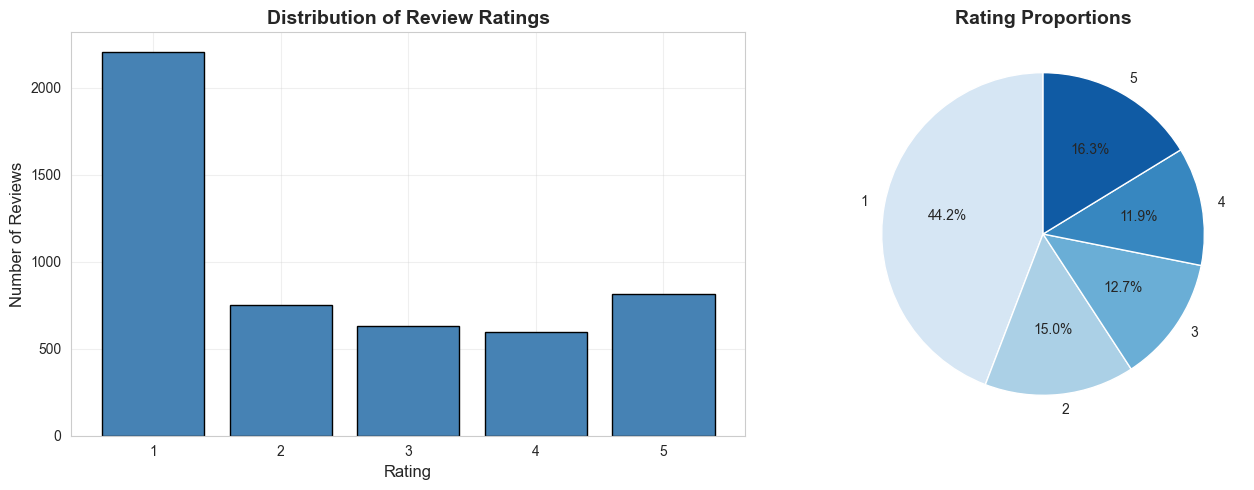


⭐ Rating Statistics:
  Mean rating: 2.41
  Median rating: 2.0
  Mode rating: 1


In [4]:
# Plot rating distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
rating_counts = df_clean['score'].value_counts().sort_index()
ax[0].bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
ax[0].set_xlabel('Rating', fontsize=12)
ax[0].set_ylabel('Number of Reviews', fontsize=12)
ax[0].set_title('Distribution of Review Ratings', fontsize=14, fontweight='bold')
ax[0].grid(True, alpha=0.3)

# Pie chart
ax[1].pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%', 
          startangle=90, colors=sns.color_palette('Blues', len(rating_counts)))
ax[1].set_title('Rating Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⭐ Rating Statistics:")
print(f"  Mean rating: {df_clean['score'].mean():.2f}")
print(f"  Median rating: {df_clean['score'].median():.1f}")
print(f"  Mode rating: {df_clean['score'].mode()[0]}")

## 5. LDA Topic Modeling

In [5]:
# Create TF-IDF vectorizer
print("📊 Vectorizing text with TF-IDF...")
vectorizer = TfidfVectorizer(
    max_features=1000,
    max_df=0.85,
    min_df=5,
    stop_words='english',
    ngram_range=(1, 2)
)

tfidf_matrix = vectorizer.fit_transform(df_clean['cleaned_text'])
feature_names = vectorizer.get_feature_names_out()

print(f"✅ Created TF-IDF matrix: {tfidf_matrix.shape}")
print(f"   {tfidf_matrix.shape[0]:,} documents, {tfidf_matrix.shape[1]:,} features")

📊 Vectorizing text with TF-IDF...
✅ Created TF-IDF matrix: (4998, 1000)
   4,998 documents, 1,000 features


In [6]:
# Train LDA model
print("🤖 Training LDA model with 5 topics...")
n_topics = 5

lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=20,
    learning_method='online',
    random_state=42,
    n_jobs=-1
)

lda_topics = lda_model.fit_transform(tfidf_matrix)

print(f"✅ LDA model trained successfully!")
print(f"   Perplexity: {lda_model.perplexity(tfidf_matrix):.2f}")

🤖 Training LDA model with 5 topics...
✅ LDA model trained successfully!
   Perplexity: 1365.17


## 6. Extract Topic Keywords

In [7]:
def get_top_words(model, feature_names, n_words=10):
    """Extract top words for each topic"""
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)
    return topics

# Get top keywords per topic
topic_keywords = get_top_words(lda_model, feature_names, n_words=10)

print("\n🏷️ Top Keywords per Topic:\n")
for idx, words in enumerate(topic_keywords):
    print(f"Topic {idx}: {', '.join(words)}")


🏷️ Top Keywords per Topic:

Topic 0: smart, shuffle, let, smart shuffle, care, yall, mode, everyday, wont let, letting
Topic 1: music, spotify, podcasts, audio, family, streaming, quality, app, best, great
Topic 2: different song, dont use, playback, lots, weeks, different, want play, perfect, selection, song plays
Topic 3: app, phone, spotify, fix, update, play, im, ive, work, playing
Topic 4: songs, ads, app, song, music, premium, spotify, like, listen, just


## 7. Assign Human-Readable Labels

In [8]:
# Manually assign labels based on keywords
topic_labels = {
    0: 'Feature Requests',
    1: 'Music Quality & Content',
    2: 'Billing & Subscription',
    3: 'Bugs & Technical Issues',
    4: 'UI/UX Feedback'
}

# Assign dominant topic to each review
df_clean['topic_id'] = lda_topics.argmax(axis=1)
df_clean['topic_probability'] = lda_topics.max(axis=1)
df_clean['topic_category'] = df_clean['topic_id'].map(topic_labels)

print("\n📊 Topic Distribution:")
topic_dist = df_clean['topic_category'].value_counts()
print(topic_dist)

print(f"\n📈 Topic Label Mapping:")
for tid, label in topic_labels.items():
    count = len(df_clean[df_clean['topic_id'] == tid])
    pct = count / len(df_clean) * 100
    print(f"  Topic {tid} ({label}): {count:,} reviews ({pct:.1f}%)")


📊 Topic Distribution:
topic_category
UI/UX Feedback             3214
Bugs & Technical Issues    1319
Music Quality & Content     465
Name: count, dtype: int64

📈 Topic Label Mapping:
  Topic 0 (Feature Requests): 0 reviews (0.0%)
  Topic 1 (Music Quality & Content): 465 reviews (9.3%)
  Topic 2 (Billing & Subscription): 0 reviews (0.0%)
  Topic 3 (Bugs & Technical Issues): 1,319 reviews (26.4%)
  Topic 4 (UI/UX Feedback): 3,214 reviews (64.3%)


## 8. Visualize Topics

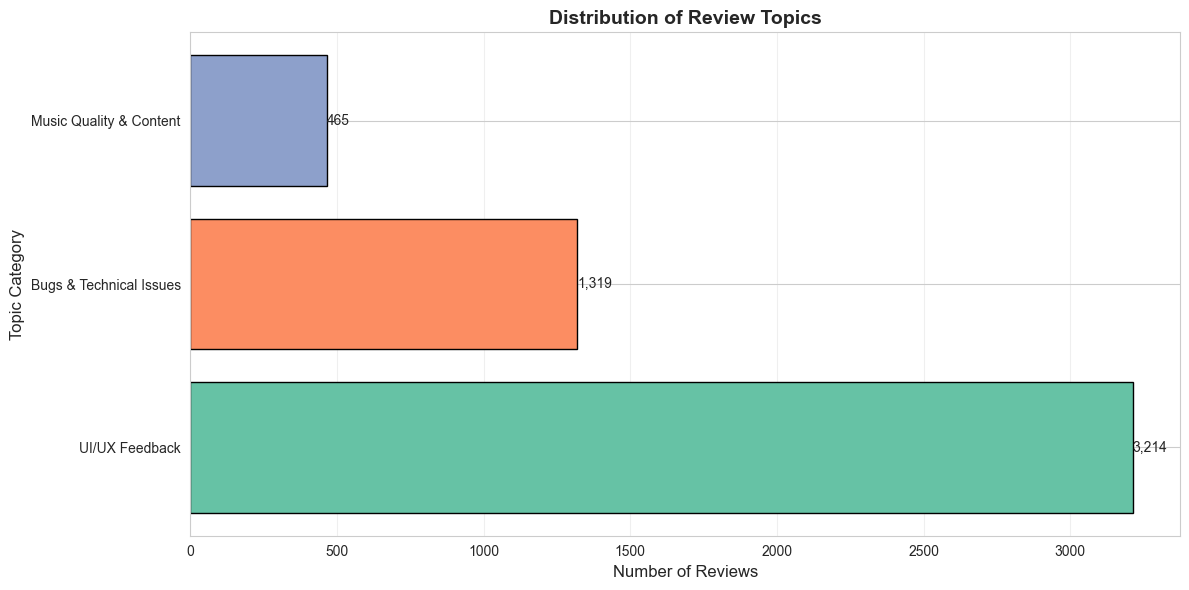

In [9]:
# Topic distribution bar chart
plt.figure(figsize=(12, 6))
topic_counts = df_clean['topic_category'].value_counts()
colors = sns.color_palette('Set2', len(topic_counts))

bars = plt.barh(topic_counts.index, topic_counts.values, color=colors, edgecolor='black')
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Topic Category', fontsize=12)
plt.title('Distribution of Review Topics', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add count labels
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 9. Rating by Topic


⭐ Average Rating by Topic:
                         mean  median  count
topic_category                              
Music Quality & Content  3.67     5.0    465
UI/UX Feedback           2.39     2.0   3214
Bugs & Technical Issues  2.01     1.0   1319


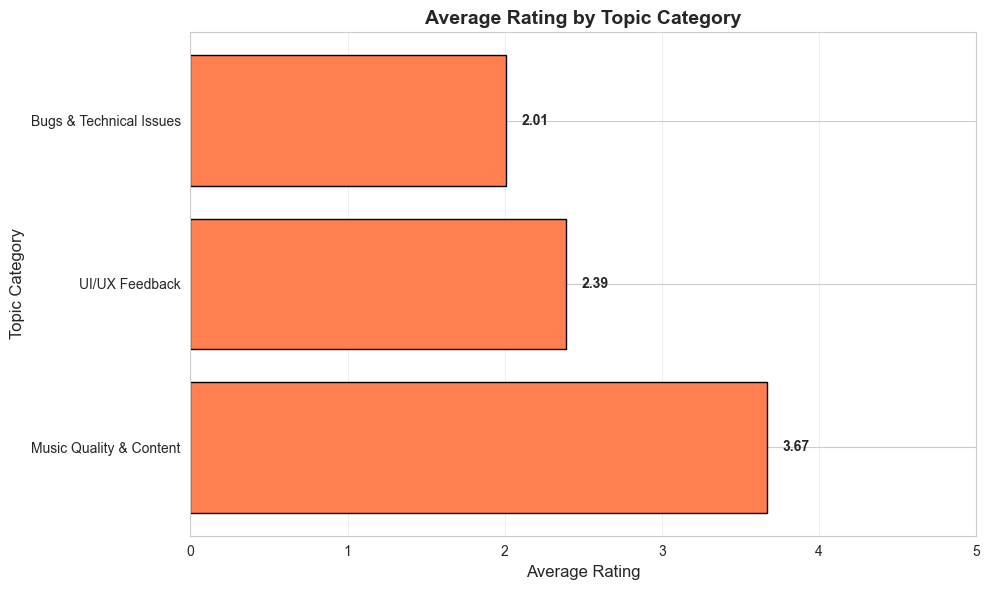

In [10]:
# Average rating per topic
topic_ratings = df_clean.groupby('topic_category')['score'].agg(['mean', 'median', 'count']).round(2)
topic_ratings = topic_ratings.sort_values('mean', ascending=False)

print("\n⭐ Average Rating by Topic:")
print(topic_ratings)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(topic_ratings.index, topic_ratings['mean'], color='coral', edgecolor='black')
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Topic Category', fontsize=12)
plt.title('Average Rating by Topic Category', fontsize=14, fontweight='bold')
plt.xlim(0, 5)
plt.grid(True, alpha=0.3, axis='x')

# Add rating labels
for idx, (topic, row) in enumerate(topic_ratings.iterrows()):
    plt.text(row['mean'] + 0.1, idx, f"{row['mean']:.2f}", 
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Sample Reviews per Topic

In [11]:
# Show sample reviews from each topic
print("\n🔍 Sample Reviews by Topic:\n")

for category in df_clean['topic_category'].value_counts().index:
    print(f"\n{'='*70}")
    print(f"📁 {category}")
    print(f"{'='*70}")
    
    samples = df_clean[df_clean['topic_category'] == category].nlargest(3, 'topic_probability')
    
    for idx, row in samples.iterrows():
        print(f"\n⭐ Rating: {row['score']}/5 (Confidence: {row['topic_probability']:.2%})")
        print(f"Review: {row['cleaned_text'][:200]}...")
        print()


🔍 Sample Reviews by Topic:


📁 UI/UX Feedback

⭐ Rating: 1/5 (Confidence: 89.10%)
Review: worst music listening app ive ever experienced in my life listening to ads is ok but you cant choose the song which you wanna play is very worst app ive been using spotify for a long time and always l...


⭐ Rating: 1/5 (Confidence: 88.90%)
Review: ive been using spotify for a long time and always loved it but now its full of ads every few minutes theres another ad which ruins the whole music vibe also i cant even play the songs i want anymore w...


⭐ Rating: 1/5 (Confidence: 88.89%)
Review: this new update is honestly terrible spotify keeps getting greedier with every update i cant even pick a song i want to listen to anymore something that used to be basic functionality now everything i...


📁 Bugs & Technical Issues

⭐ Rating: 1/5 (Confidence: 87.93%)
Review: has been super buggy lately podcasts just stop playing randonly wont connect to my alexa device through spotify connect the app wont sh

## 11. Save Results

In [12]:
import os

# Save processed data
os.makedirs('../data/processed', exist_ok=True)
output_path = '../data/processed/reviews_with_topics.csv'

df_clean.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"✅ Results saved to: {output_path}")
print(f"\n📊 Final Summary:")
print(f"  Total reviews processed: {len(df_clean):,}")
print(f"  Number of topics: {n_topics}")
print(f"  Average topic confidence: {df_clean['topic_probability'].mean():.2%}")
print(f"\nTop category: {df_clean['topic_category'].value_counts().index[0]}")
print(f"  ({df_clean['topic_category'].value_counts().iloc[0]:,} reviews)")

✅ Results saved to: ../data/processed/reviews_with_topics.csv

📊 Final Summary:
  Total reviews processed: 4,998
  Number of topics: 5
  Average topic confidence: 72.89%

Top category: UI/UX Feedback
  (3,214 reviews)
